In [1]:
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates


In [2]:
roots = "D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Output_Data/"
file_names = ['wave_dt_stamp.pkl', 'wave_dt.pkl']

# Dicionário para armazenar os dados já processados de velocidade
data = {}

# Loop através dos nomes dos arquivos e carregue os dados usando pickle
for file_name in file_names:
    with open(roots+file_name, 'rb') as file:
        data[file_name.replace('.pkl', '')] = pickle.load(file)
t_II = data['wave_dt_stamp'][:]
t = data['wave_dt'][:]

In [3]:
met_data = np.genfromtxt('D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Raw_Data/SIMCOSTA_RS-4_MET_2019-02-19_2021-04-03.tab', delimiter='\t')

# Filtra os dados faltantes ou não numéricos
mask = np.logical_not(np.isnan(met_data).any(axis=1))
met_data = met_data[mask]

# Define o intervalo de dados que será utilizado
inicio = np.where(met_data[:,0] == 2020)[0][0]
fim = np.where(met_data[:,0] == 2021)[0][0]
met_data = met_data[inicio:fim]

met_t = []
Wind_U = []
Wind_V = []
time_II =[]

for row in met_data:
    data = datetime(int(row[0]), int(row[1]), int(row[2]), int(row[3]), int(row[4]), int(row[5]))
    met_t.append(data)
    tsh_tempo_II = data.timestamp()
    time_II.append(tsh_tempo_II)
    
    dirc = row[13]
    vel = row[11]
    
    # Calcula as componentes U e V do vento
    if 0 <= dirc < 90:
        tt_U = np.sin(np.radians(dirc)) * vel
        tt_V = np.cos(np.radians(dirc)) * vel
    elif 90 <= dirc < 180:
        dirc = 180 - dirc
        tt_U = np.sin(np.radians(dirc)) * vel
        tt_V = -np.cos(np.radians(dirc)) * vel
    elif 180 <= dirc < 270:
        dirc = dirc - 180
        tt_U = -np.sin(np.radians(dirc)) * vel
        tt_V = -np.cos(np.radians(dirc)) * vel
    else:
        dirc = 360 - dirc
        tt_U = -np.sin(np.radians(dirc)) * vel
        tt_V = np.cos(np.radians(dirc)) * vel
                
    Wind_U.append(tt_U)
    Wind_V.append(tt_V)
    
Wind_U_intp = np.interp(t_II, time_II, Wind_U)
Wind_V_intp = np.interp(t_II, time_II, Wind_V)


In [4]:
#rotacionando os dados de vel. em 57 graus.
M = np.sqrt(Wind_U_intp**2+Wind_V_intp**2)
UV_dir = np.arctan2(Wind_V_intp/M, Wind_U_intp/M) 
UV_dir_degrees = UV_dir * 180/np.pi 

np.shape(UV_dir_degrees)          

U_spin = np.zeros(len(M))
V_spin = np.zeros(len(M))



for j in range(len(M)):
    if (M[j] != 0):
        U_spin[j] = M[j]*np.cos(UV_dir[j]-np.radians(29))
        V_spin[j] = M[j]*np.sin(UV_dir[j]-np.radians(29))

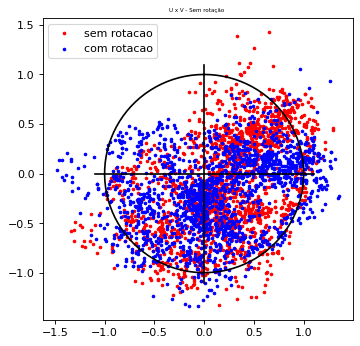

In [5]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 80)


n = np.linspace(0, 2*np.pi, 100)
circ_x = np.sin(n)
circ_y = np.cos(n)

ax.plot(circ_x, circ_y,'k')
ax.plot([0,0], [-1.1, 1.1], 'k')
ax.plot([-1.1, 1.1], [0, 0], 'k')
ax.axis('equal')


plt.title("U x V - Sem rotação ", fontsize=5)
ax.scatter(Wind_U_intp/10,Wind_V_intp/10,c = 'r',cmap=plt.cm.jet, s = 5, label = 'sem rotacao')
ax.scatter(U_spin/10,V_spin/10,c = 'b',cmap=plt.cm.jet, s = 5, label = 'com rotacao')
ax.legend()

In [6]:
with open(roots+'Wind_U_spin.pkl', 'wb') as file:
    pickle.dump(U_spin, file)
    
with open(roots+'Wind_V_spin.pkl', 'wb') as file:
    pickle.dump(V_spin, file)
